## Energy Resolution of Germanium detectors

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

_testo del progetto_  

NaI and Germanium detectors have wide fields of application for γ- and X-ray spectrometry thanks to their good energy resolution. The energy resolution of these detectors is defined as the width of the detected energy spectra peaks (FWHM); it depends on  
    - the statistics of the charge creation process  
    - the properties of the detector, and primarly its charge cllelction efficency   
    - the electronics noise  

The resolution can be expressed as the suquared sum of two terms:   
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$   
where the first term depends on teh detector properties as:  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$   
with $F$ the _Fano factor_,  
$E_{\gamma}$  the energy of the photon deposited energy(?)  
$w$ the electron hole-porduced energy threshold in germanium (w ~ 3eV).

The $w_e$ term in eq.1 is connected with the readout electronics and depends on the detector capacitance, the size of the detector and the bias voltage.

The following plot shows an uncalibrated energy spectrum collected with a Germanium detector
irradiated by a combination of three sources: 241Am, 60Co and 137Cs[2].

According to [2], the source nuclides emit the following photons:
Nuclide 241Am 137Cs 60Co
Photon energy (keV) 59.54 661.66 1173.24 1332.51
and these are the first four peaks (starting from the left side) visible in the figure. Similar spectra have
been collected with other gamma sources (i.e. Th-228).

Detailed Steps
##### 1. Understand the Data and Model

The energy resolution (FWHM) of the Germanium detectors is given by:  
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$


with  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$  


    ​

    Here, F is the Fano factor, $E_{\gamma}$​ is the energy of the photon, and w is the electron-hole production energy threshold in Germanium (approximately 3 eV).

    You need to determine w_d_​ and w_e_​ for your data.

##### 2. Define the Model for Fitting Peaks

Identify the function you will use to fit the peaks. A common choice for spectral peaks is the Gaussian function.
Define the full model incorporating the equation for FWHM and how it relates to the observed data.

Use a Gaussian function to model the peaks in the energy spectra:
$$f(E)=A * exp⁡(−\frac{(E−μ)^2}{2σ^2})$$
    
where μ is the peak center, σ is the standard deviation related to FWHM by $FWHM = 2 * \sqrt{2 * \log{2}} * \sigma$, and A is the amplitude.

##### 3. Set Up Bayesian Inference

Define prior distributions for the parameters μ, σ, A, $w_d$​, and $w_e$​. For example:  
$μ∼N(μ_0,(σ_{\mu})^2)$
$σ∼N(σ_0,σ_σ^2)$  
$A∼N(A_0,σ_A^2)$  
$w_d∼N(w_{d0},σ_{w_d}^2)$  
$w_e∼N(w_{e0},σ_{w_e}^2)$

where N denotes a normal distribution with specified mean and variance.

##### 4. Perform Bayesian Inference

Use a Bayesian inference library like Stan to perform Markov Chain Monte Carlo (MCMC) sampling to obtain the posterior distributions of the parameters.



##### 5. Validate and Interpret the Results

Check the trace plots and posterior distributions to ensure the MCMC chains have converged.
Compare the fitted model to the observed data using posterior predictive checks.

##### 6. Report the Results

Summarize the parameter estimates, including credible intervals.
Provide visualizations, such as trace plots and the fitted spectrum overlaid on the observed data.

### Theory Behind Bayesian Inference

Bayesian inference combines prior knowledge with observed data to update the probability of a hypothesis. The steps are:

- Prior Distribution: Represents your initial beliefs about the parameters before seeing the data.   
- Likelihood: Represents the probability of the observed data given the parameters.  
- Posterior Distribution: Updated beliefs about the parameters after considering the data, obtained via Bayes' theorem:  
    $P(θ∣data) ∝ P(data∣θ)P(θ)$


MCMC methods, such as the Metropolis-Hastings algorithm, are used to sample from the posterior distribution when it cannot be computed analytically.

Metropolis-Hastings: Proposes new parameter values and accepts them based on an acceptance criterion.


## 1. 
### Using statistical methods similar to that presented during the course, infere the FWHM of each γ peak for all available γ sources

### a. Load the required libraries

In [1]:
# Load the libraries
library(rstan)
library(ggplot2)
library(bayesplot)

library(dplyr)
library(nlstools)
library(pracma)

library(gridExtra)

# Configure rstan
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Caricamento del pacchetto richiesto: StanHeaders




rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union



'nlstools' has been loaded.


IMPORTANT NO

### b. Load the data

I dati nei files rappresentano un tipico spettro energetico ottenuto da un rivelatore, in questo caso presumibilmente un rivelatore di germanio, dopo essere stato irradiato da una sorgente contenente Cesio-137 (Cs-137) (es). Ogni riga del file contiene due valori:

    Il primo valore rappresenta il canale del rivelatore, che è essenzialmente l'indice o la posizione del dato nel file.  
    Il secondo valore rappresenta il numero di conteggi (o eventi) registrati in quel canale durante la misura dell'energia.  

Canale del rivelatore:

    Ogni rivelatore di energia (come un rivelatore di germanio) divide l'intervallo di energia che può misurare in canali discreti. Ogni canale corrisponde a una determinata gamma di energia che il rivelatore è in grado di rilevare.

Conteggi:

    I conteggi registrati rappresentano il numero di volte che il rivelatore ha rilevato un evento energetico (un fotone gamma, nel caso di un rivelatore di germanio) in quel particolare canale durante l'esperimento.



In [11]:
# Load the data
gr11_co60 <- read.table("gr11_co60.txt", header = FALSE)
gr11_cs137 <- read.table("gr11_cs137.txt", header = FALSE)
gr11_na22 <- read.table("gr11_na22.txt", header = FALSE)
IC48A_AmCsCo <- read.table("IC48A_AmCsCo.txt", header = FALSE)
IC48A_Th <- read.table("IC48A_Th.txt", header = FALSE)

# Assign column names
colnames(gr11_co60) <- c("Channel", "Count")
colnames(gr11_cs137) <- c("Channel", "Count")
colnames(gr11_na22) <- c("Channel", "Count")
colnames(IC48A_AmCsCo) <- c("Channel", "Count")
colnames(IC48A_Th) <- c("Channel", "Count")

# Aggiungi la colonna log_Count
gr11_co60$log_Count <- log(gr11_co60$Count)
gr11_cs137$log_Count <- log(gr11_cs137$Count)
gr11_na22$log_Count <- log(gr11_na22$Count)
IC48A_AmCsCo$log_Count <- log(IC48A_AmCsCo$Count)
IC48A_Th$log_Count <- log(IC48A_Th$Count)

# Rimuovi le righe con Count < 0
gr11_co60 <- gr11_co60[gr11_co60$Count >= 0, ]
gr11_cs137 <- gr11_cs137[gr11_cs137$Count >= 0, ]
gr11_na22 <- gr11_na22[gr11_na22$Count >= 0, ]
IC48A_AmCsCo <- IC48A_AmCsCo[IC48A_AmCsCo$Count >= 0, ]
IC48A_Th <- IC48A_Th[IC48A_Th$Count >= 0, ]

### c. Inspect the Data - Plot the Spectra

Ogni picco nello spettro rappresenta un'energia specifica dei fotoni gamma emessi dalle sorgenti radioattive, come Co-60, Cs-137, Na-22, AmCsCo, o Th. L'analisi di questi spettri permette di identificare e caratterizzare le sorgenti radioattive presenti, valutare la risoluzione energetica del rivelatore e studiare altre proprietà del rivelatore e delle sorgenti.

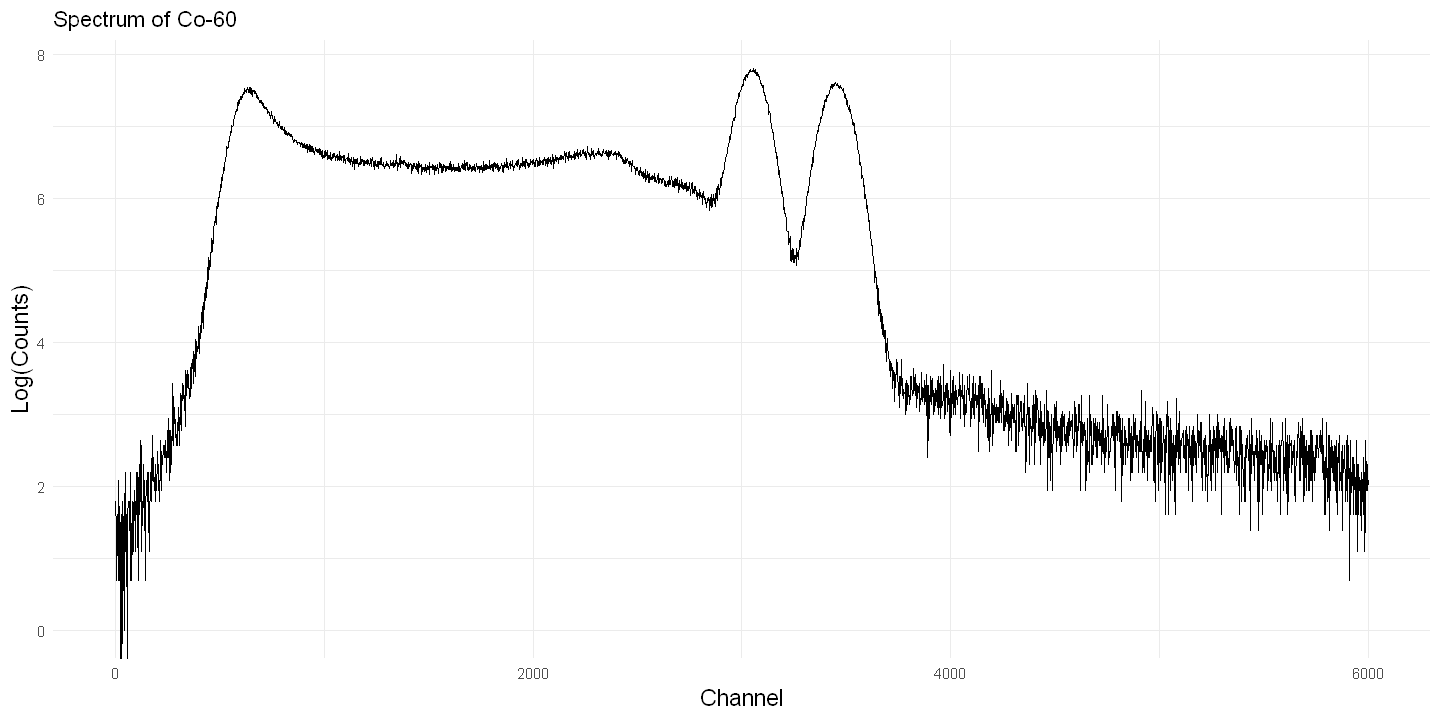

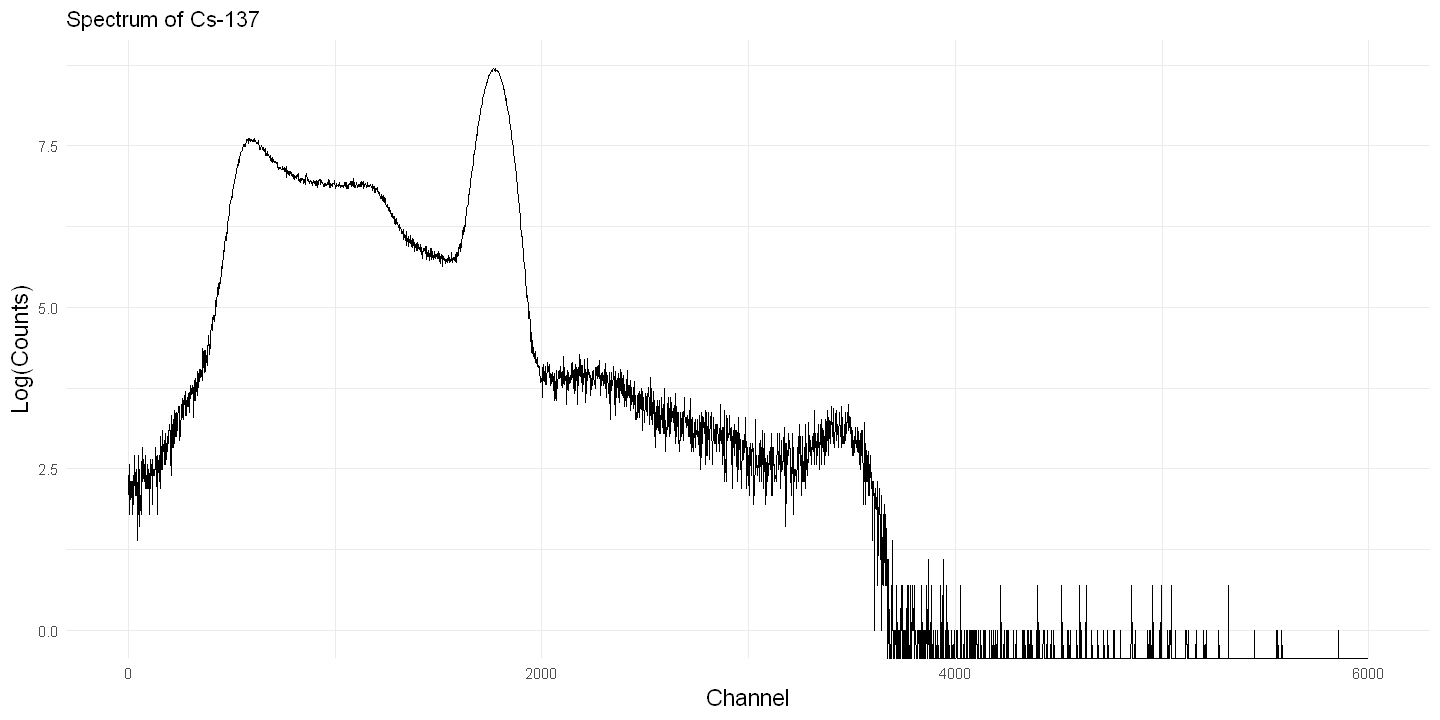

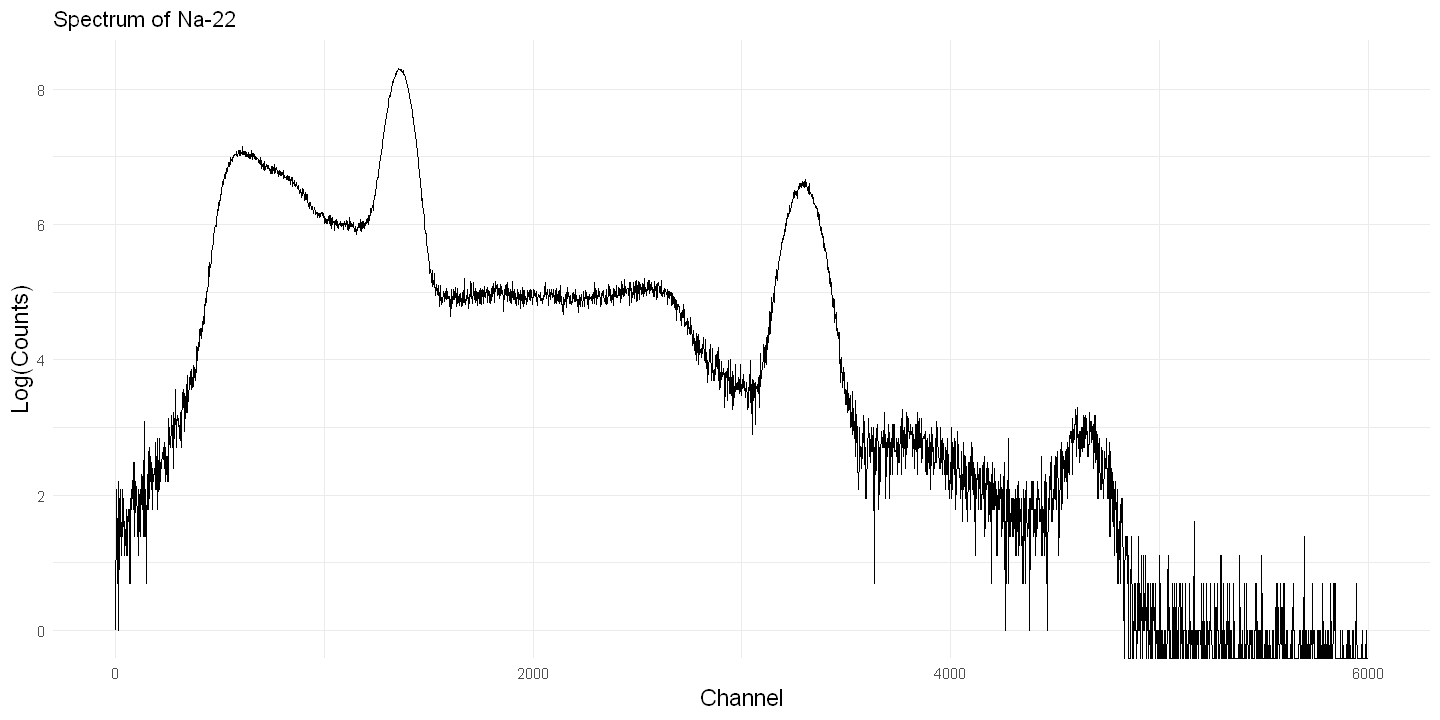

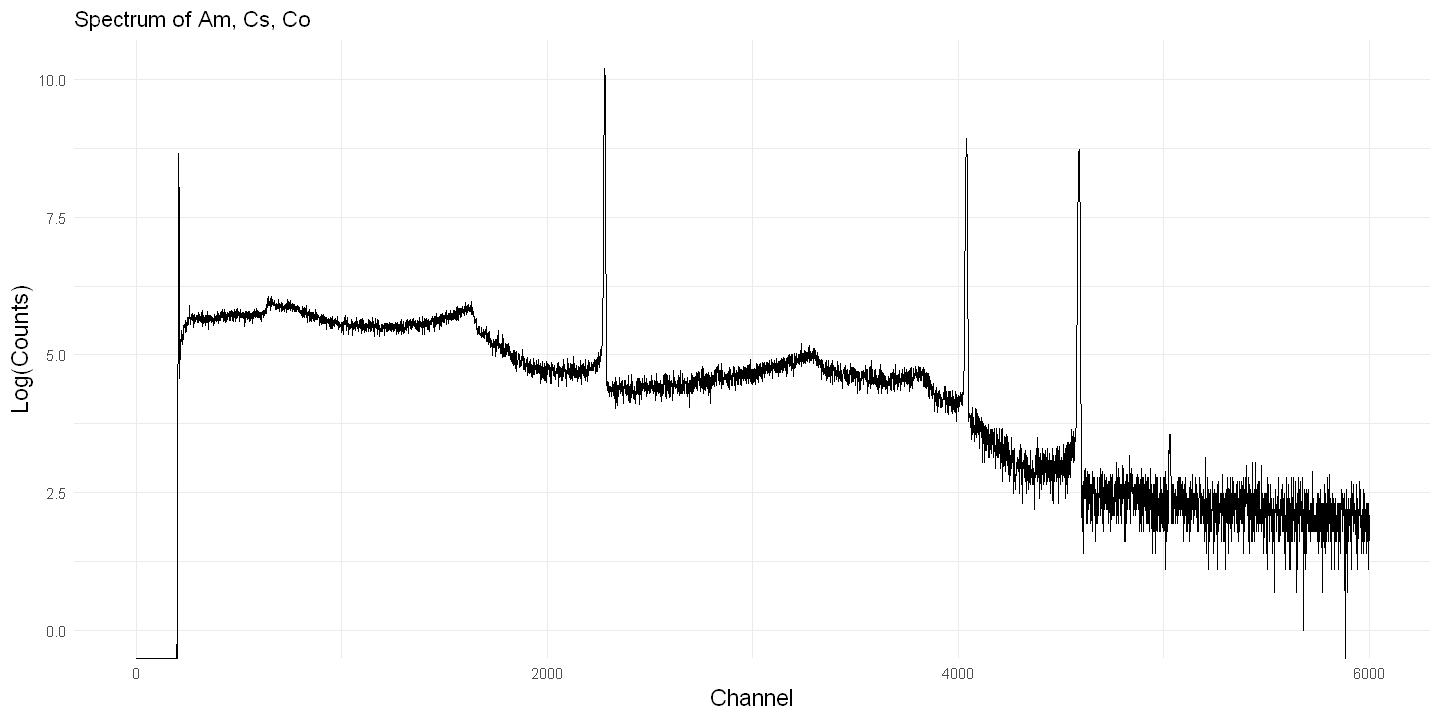

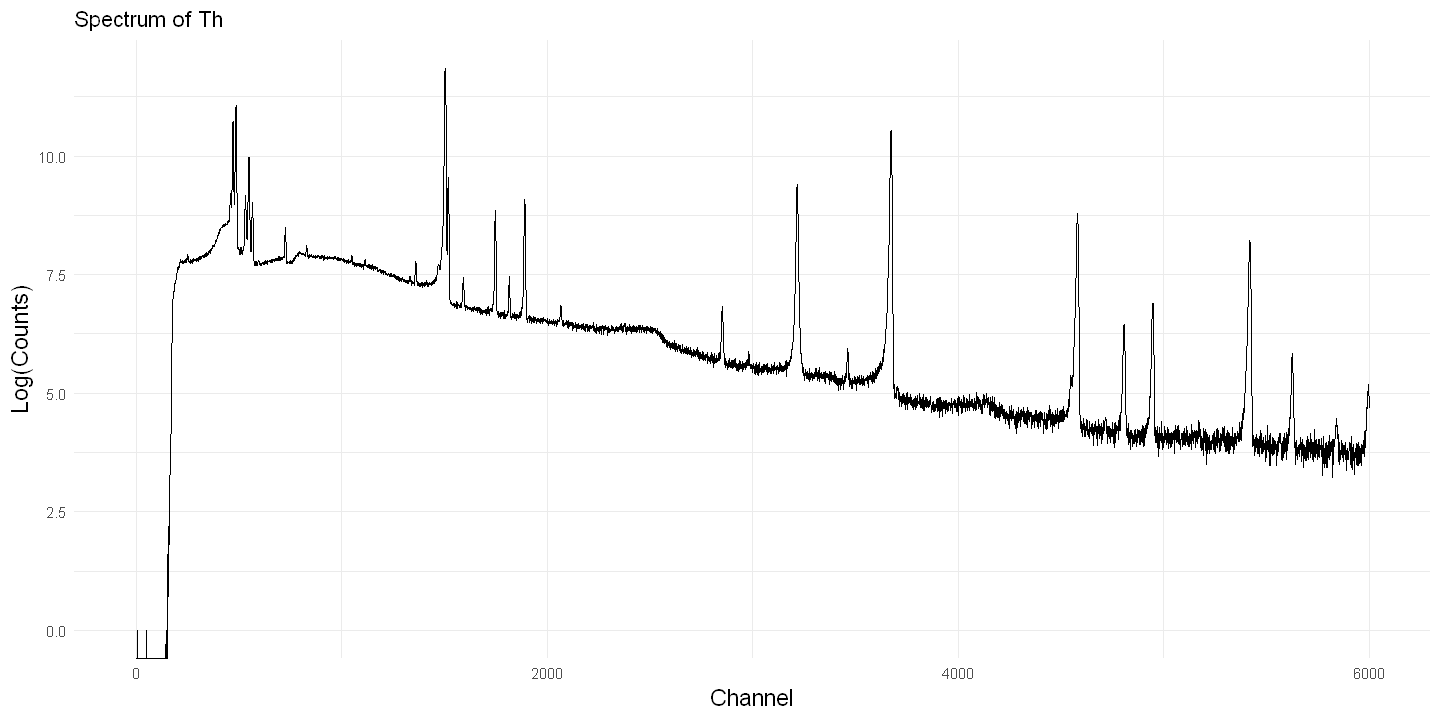

In [12]:
# Plot function
options(repr.plot.width = 12, repr.plot.height = 6)
plot_spectrum <- function(data, title) {
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line(col='black', lwd=0.2, na.rm = TRUE) +  # Aggiungi na.rm = TRUE per rimuovere NA
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    xlim(1, 6000) +
    theme(axis.title = element_text(size = 14))  # Opzionale: aumenta la dimensione del testo degli assi
}

# Plot each spectrum
plot_spectrum(gr11_co60, "Spectrum of Co-60")
plot_spectrum(gr11_cs137, "Spectrum of Cs-137")
plot_spectrum(gr11_na22, "Spectrum of Na-22")
plot_spectrum(IC48A_AmCsCo, "Spectrum of Am, Cs, Co")
plot_spectrum(IC48A_Th, "Spectrum of Th")


### d. Find Peaks Precisely and Infer FWHM

La funzione movavg dalla libreria pracma viene utilizzata per applicare una media mobile semplice ai valori nella colonna Value. La media mobile aiuta a ridurre il rumore nei dati, facilitando l'identificazione dei picchi principali.
La media mobile viene calcolata su una finestra di dimensione window_size (5 per default).
I valori levigati vengono salvati in smoothed_values

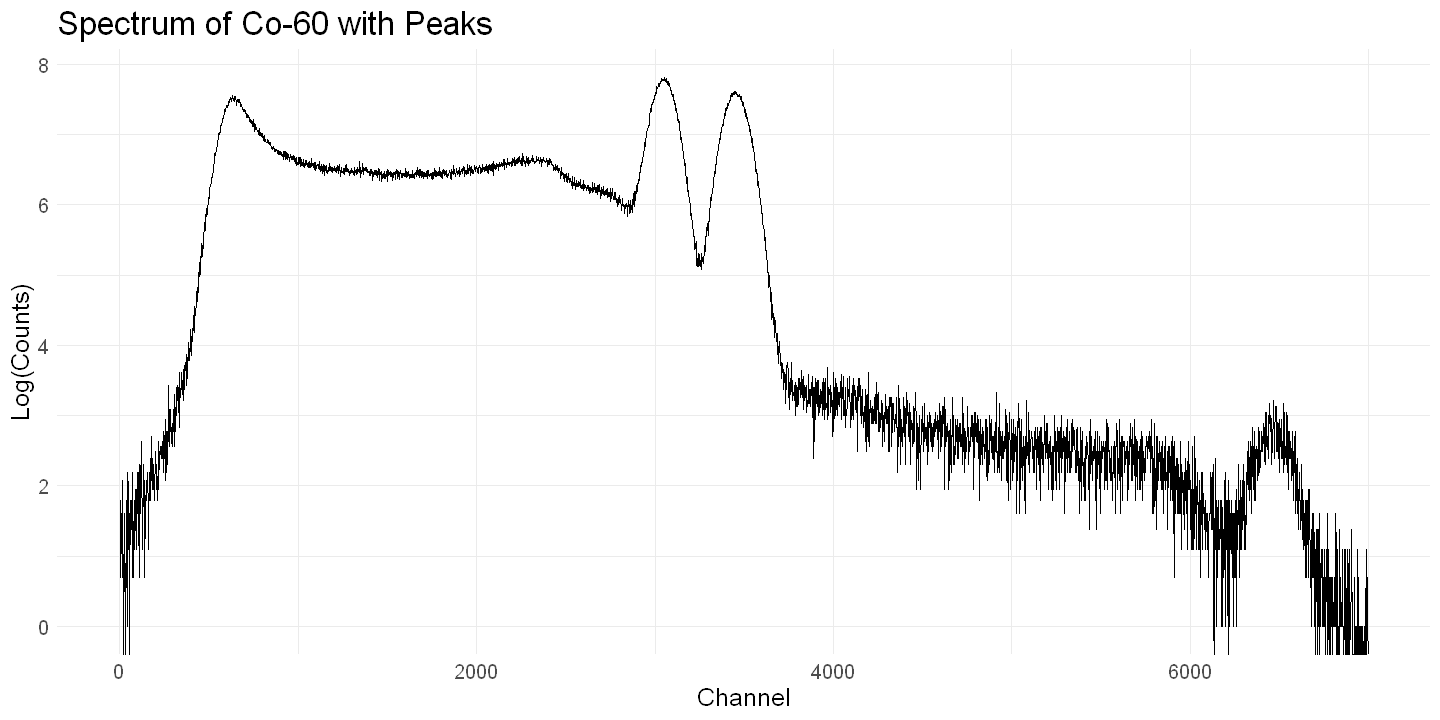

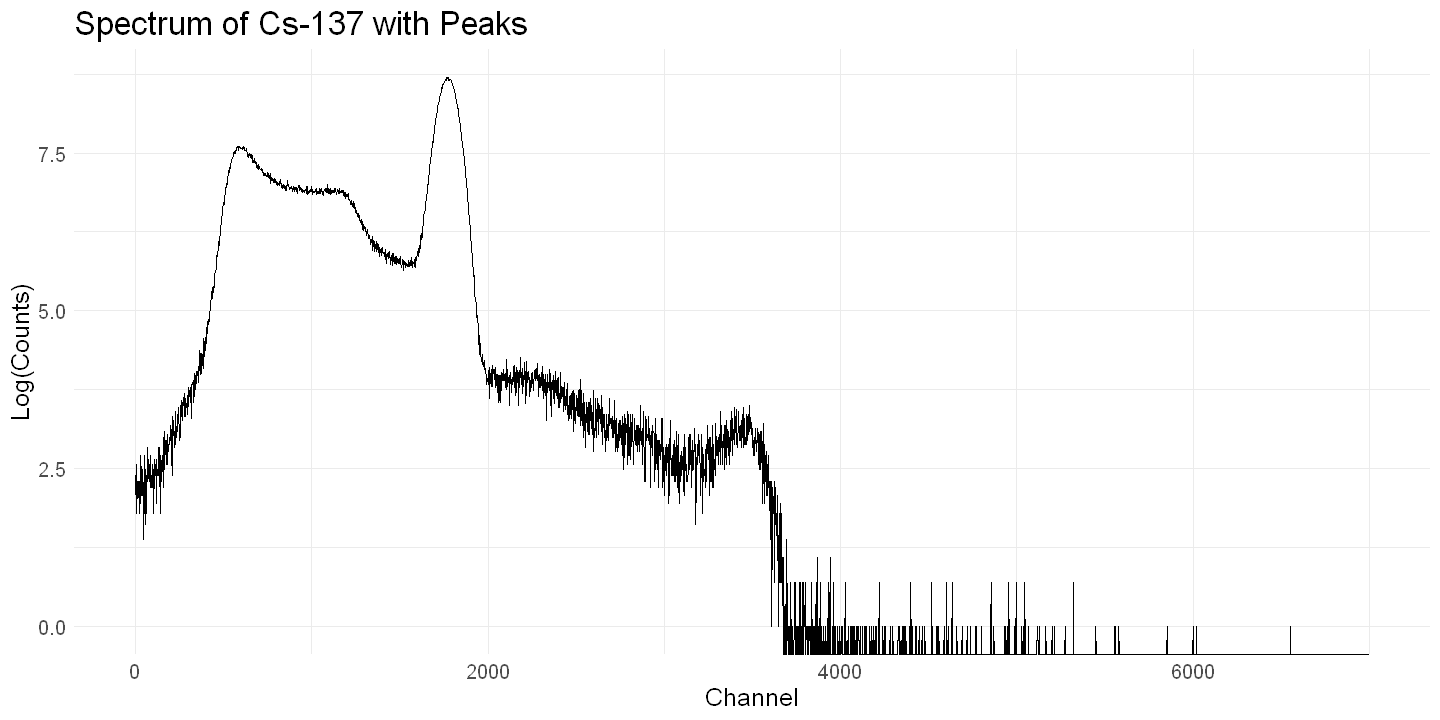

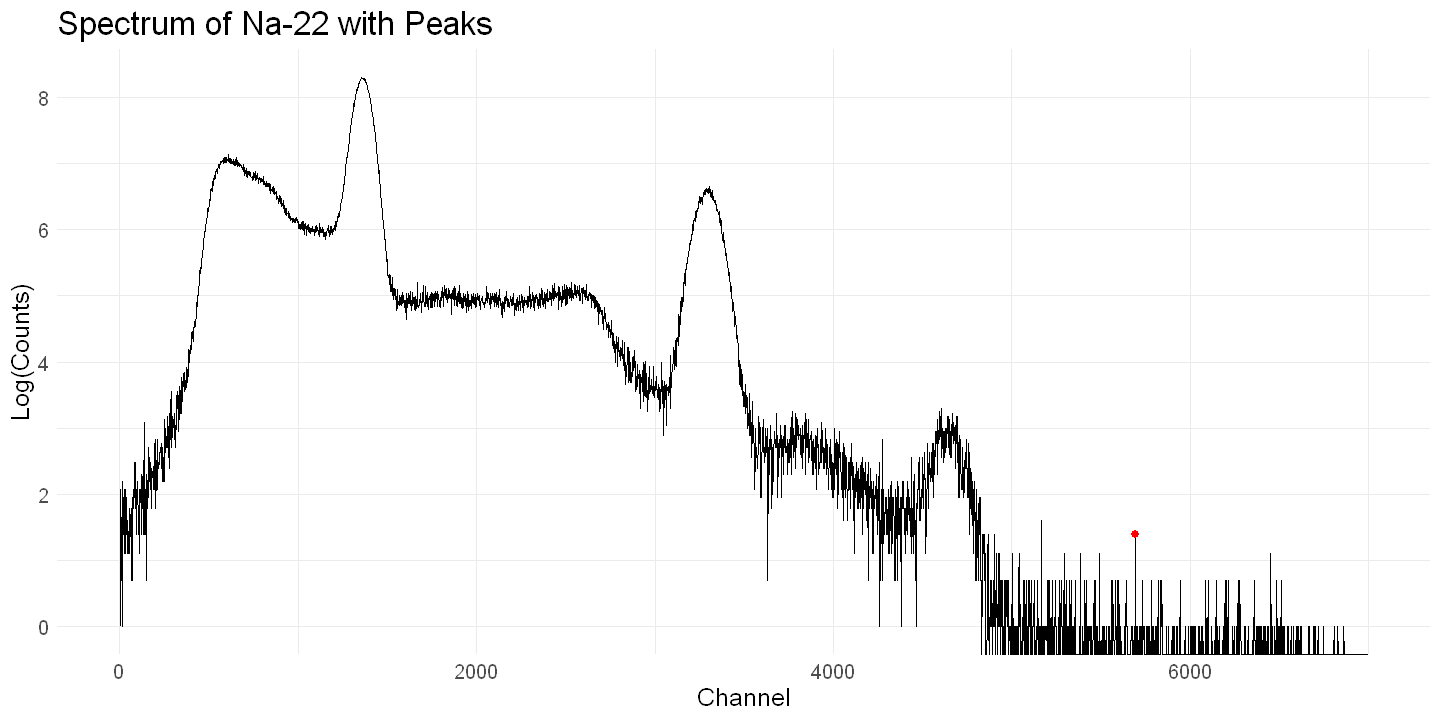

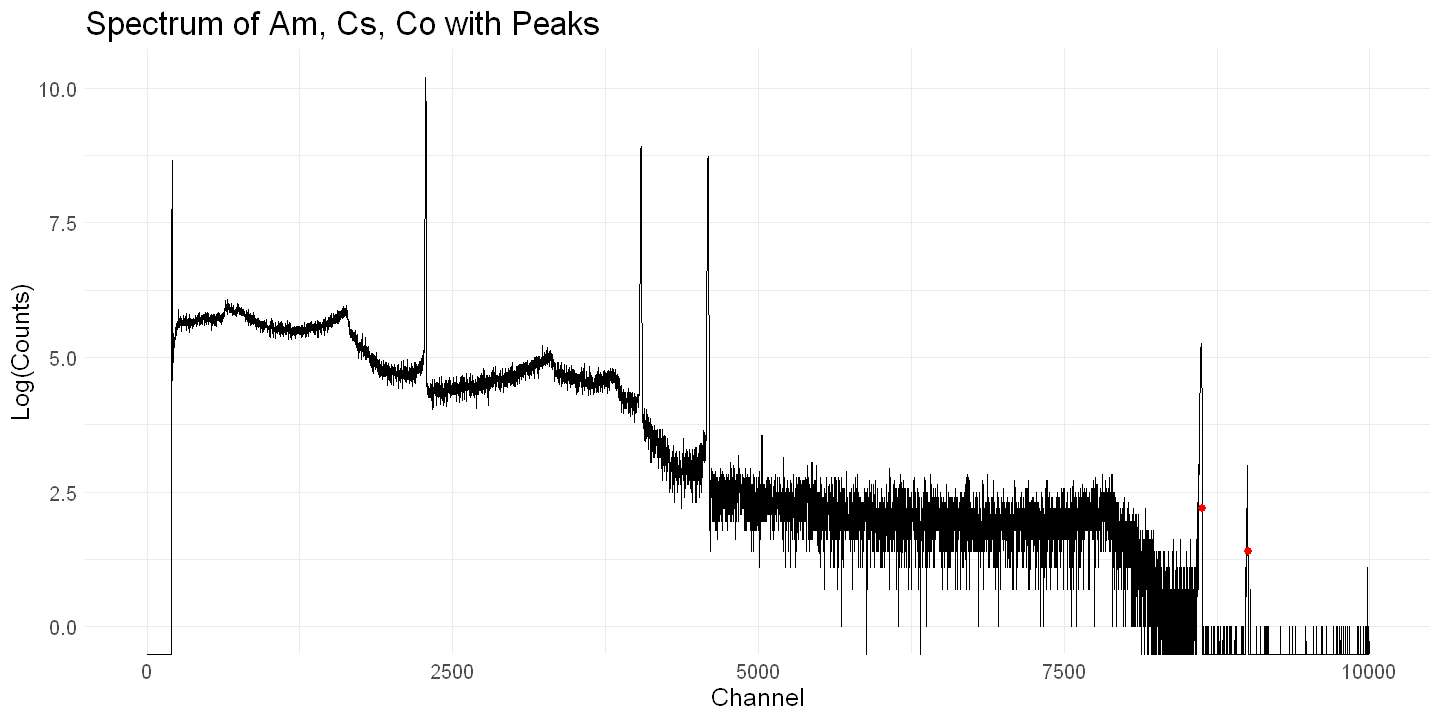

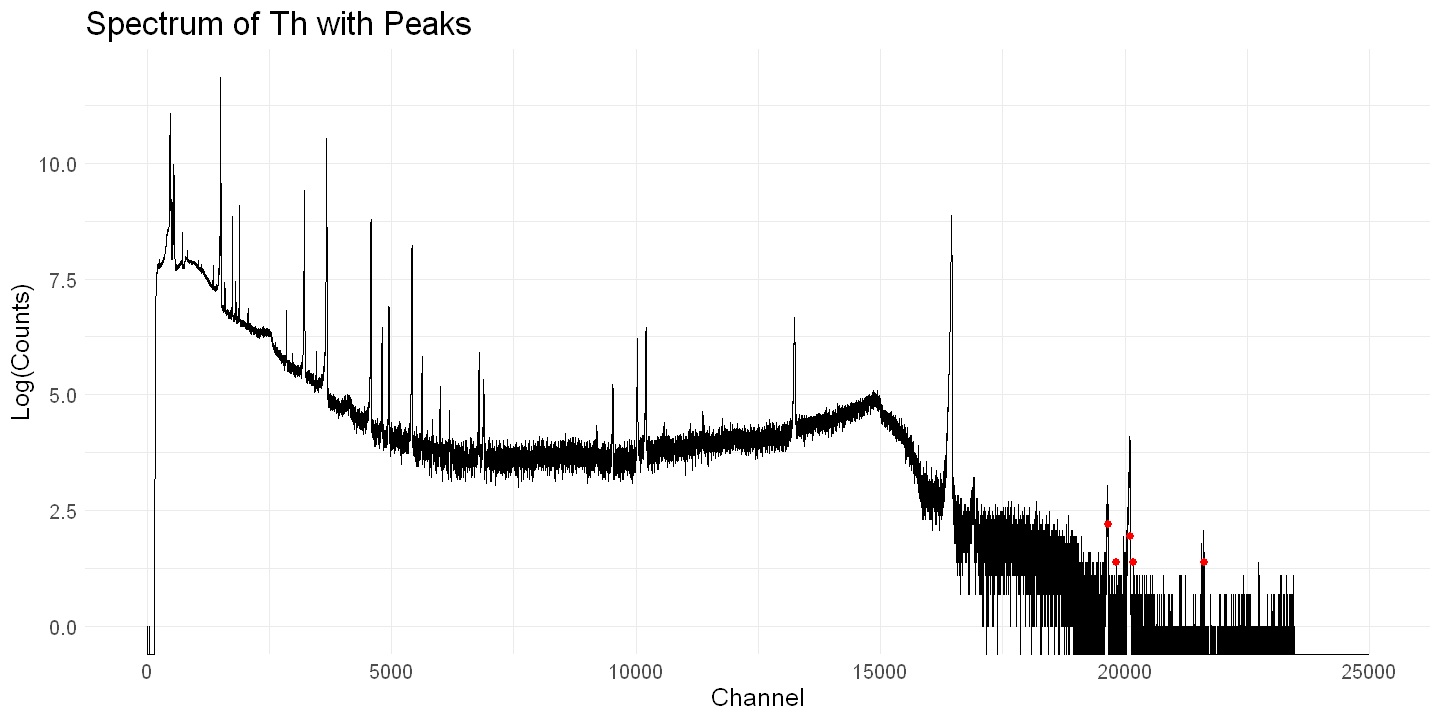

In [22]:
# Function to find peaks based on threshold and minimum distance
find_peaks <- function(data, minpeakheight, minpeakdistance) {
  peaks <- which(data$log_Count >= minpeakheight)  # Trova i picchi sopra il threshold
  peaks <- peaks[diff(peaks) > minpeakdistance]  # Applica la distanza minima tra picchi
  return(peaks)
}

# Function to find and plot peaks
find_and_plot_peaks <- function(data, title, minpeakheight_factor, minpeakdistance, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    stop("Smoothed data not available. Implement smoothing function if needed.")
  }
  
  # Find peaks
  peaks <- find_peaks(data, minpeakheight_factor * max(data$log_Count), minpeakdistance)
  peak_positions <- data$Channel[peaks]  # Recupera le posizioni dei picchi
  
  # Plot the data with identified peaks
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line() +
    geom_point(data = data[peaks, ], aes(x = Channel, y = log_Count), color = "red", size = 2) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

# Test function with different parameters
find_and_plot_peaks(gr11_co60, "Spectrum of Co-60 with Peaks", minpeakheight_factor = 0.5, minpeakdistance = 100, apply_smoothing = FALSE)
find_and_plot_peaks(gr11_cs137, "Spectrum of Cs-137 with Peaks", minpeakheight_factor = 0.3, minpeakdistance = 100, apply_smoothing = FALSE)
find_and_plot_peaks(gr11_na22, "Spectrum of Na-22 with Peaks", minpeakheight_factor = 0.1, minpeakdistance = 300, apply_smoothing = FALSE)
find_and_plot_peaks(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks", minpeakheight_factor = 0.1, minpeakdistance = 50, apply_smoothing = FALSE)
find_and_plot_peaks(IC48A_Th, "Spectrum of Th with Peaks", minpeakheight_factor = 0.1, minpeakdistance = 50, apply_smoothing = FALSE)

### e. Fit Gaussian and Calculate FWHM - - -   DA SISTEMARE ! - -  -
Vedere se trova le FWHM per tutti i picchi ( non so se vada fatto)- non mi sembra che fitti benissimo su tutti

In [ ]:
# Function to fit Gaussian and calculate FWHM
fit_gaussian <- function(data, peak_position) {
  # Ensure peak_position is treated as a single value
  peak_position <- as.numeric(peak_position)
  
  # Subset the data around the peak
  subset_data <- data %>%
    filter(Row >= (peak_position - 50) & Row <= (peak_position + 50))
  
  # Improved initial guess for parameters: amplitude, mean, standard deviation
  start_params <- list(a = max(subset_data$Value), 
                       b = peak_position, 
                       c = sd(subset_data$Row))
  
  # Fit Gaussian model
  fit <- tryCatch({
    nls(Value ~ a * exp(-(Row - b)^2 / (2 * c^2)), 
        data = subset_data, 
        start = start_params,
        control = nls.control(minFactor = 1/2048, maxiter = 100))
  }, error = function(e) {
    NULL
  })
  
  if (!is.null(fit)) {
    # Extract fitted parameters
    params <- summary(fit)$coefficients
    amplitude <- params["a", "Estimate"]
    mean <- params["b", "Estimate"]
    sigma <- params["c", "Estimate"]
    
    # Calculate FWHM
    FWHM <- 2 * sqrt(2 * log(2)) * sigma
    
    return(list(mean = mean, FWHM = FWHM, fit = fit))
  } else {
    return(NULL)
  }
}

# Function to apply Gaussian fit to peaks and plot results
apply_gaussian_fit <- function(data, title, minpeakheight_factor = 0.1, minpeakdistance = 20, window_size = 5, apply_smoothing = TRUE) {
  peak_positions <- find_and_plot_peaks(data, title, minpeakheight_factor, minpeakdistance, window_size, apply_smoothing)
  
  fits <- lapply(peak_positions, function(pos) fit_gaussian(data, pos))
  
  for (fit in fits) {
    if (!is.null(fit)) {
      # Extract the fitted parameters
      mean <- fit$mean
      FWHM <- fit$FWHM
      fit_model <- fit$fit
      
      # Plot the Gaussian fit
      plot <- ggplot(data, aes(x = Row, y = Value)) +
        geom_line(color = '#862424') +
        geom_point(data = data[peak_positions, ], aes(x = Row, y = Value), color = "red", size = 2) +
        stat_function(fun = function(x) coef(fit_model)["a"] * exp(-(x - coef(fit_model)["b"])^2 / (2 * coef(fit_model)["c"]^2)), color = 'blue') +
        ggtitle(paste(title, "\nFWHM:", round(FWHM, 2))) +
        xlab("Channel") +
        ylab("Counts") +
        theme_minimal()
      
      print(plot)
    }
  }
}





[[1]]
[1] 1584.911

[[2]]
[1] NA

[[3]]
[1] NA

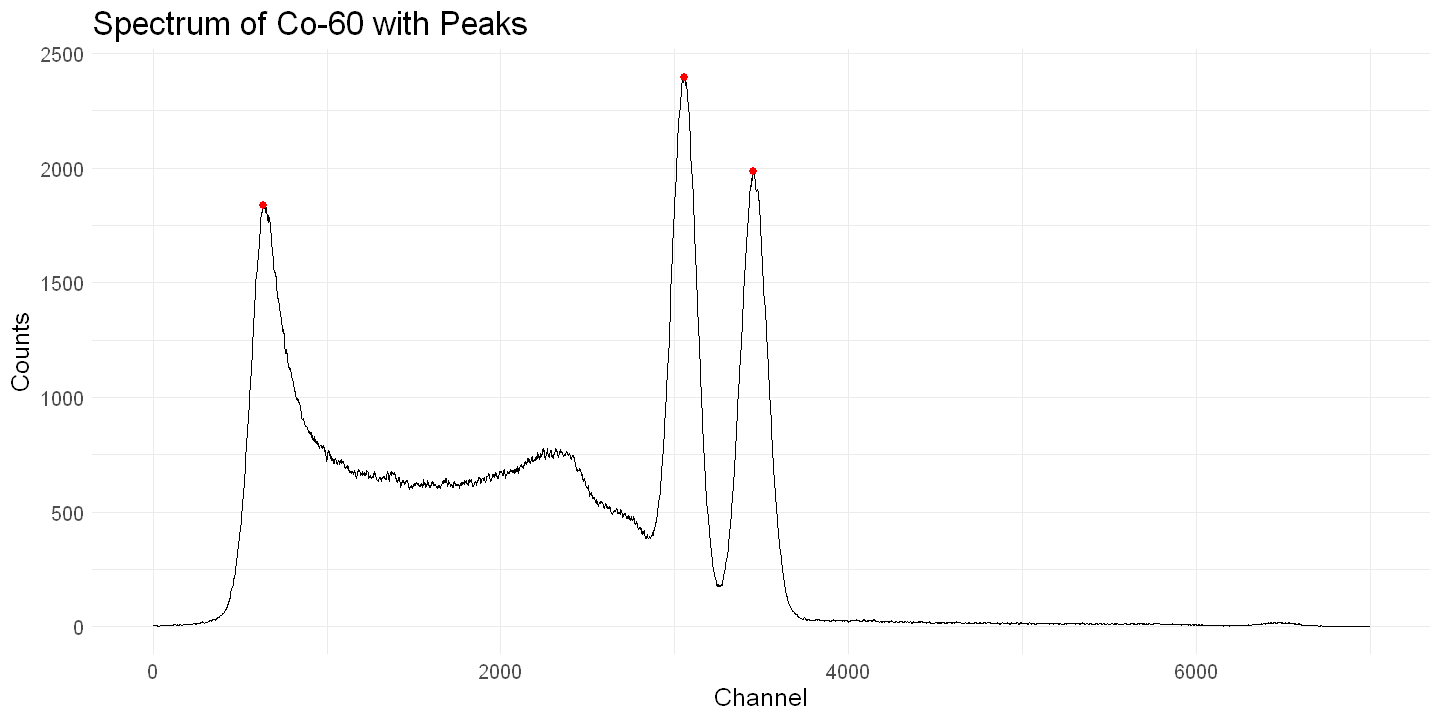

[[1]]
[1] NA

[[2]]
[1] NA



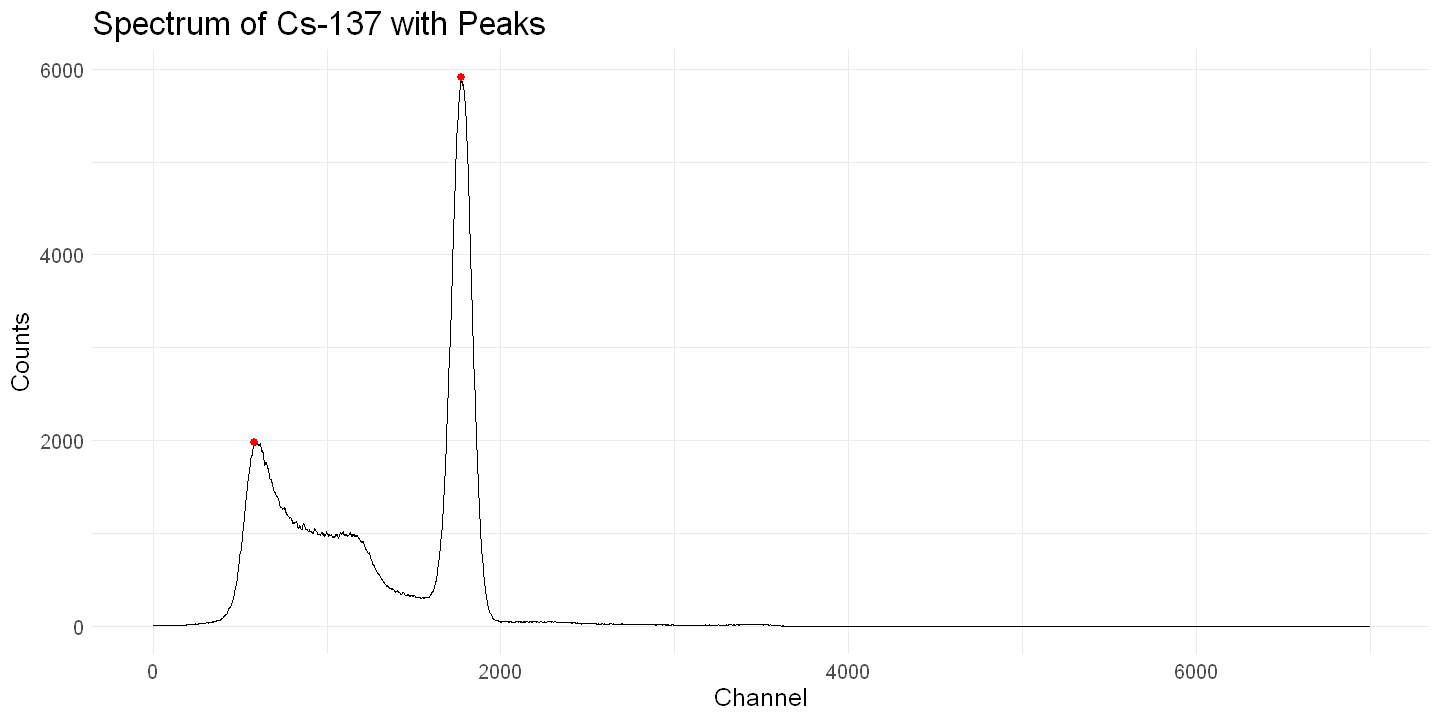

[[1]]
[1] 554.5626

[[2]]
[1] NA

[[3]]
[1] NA



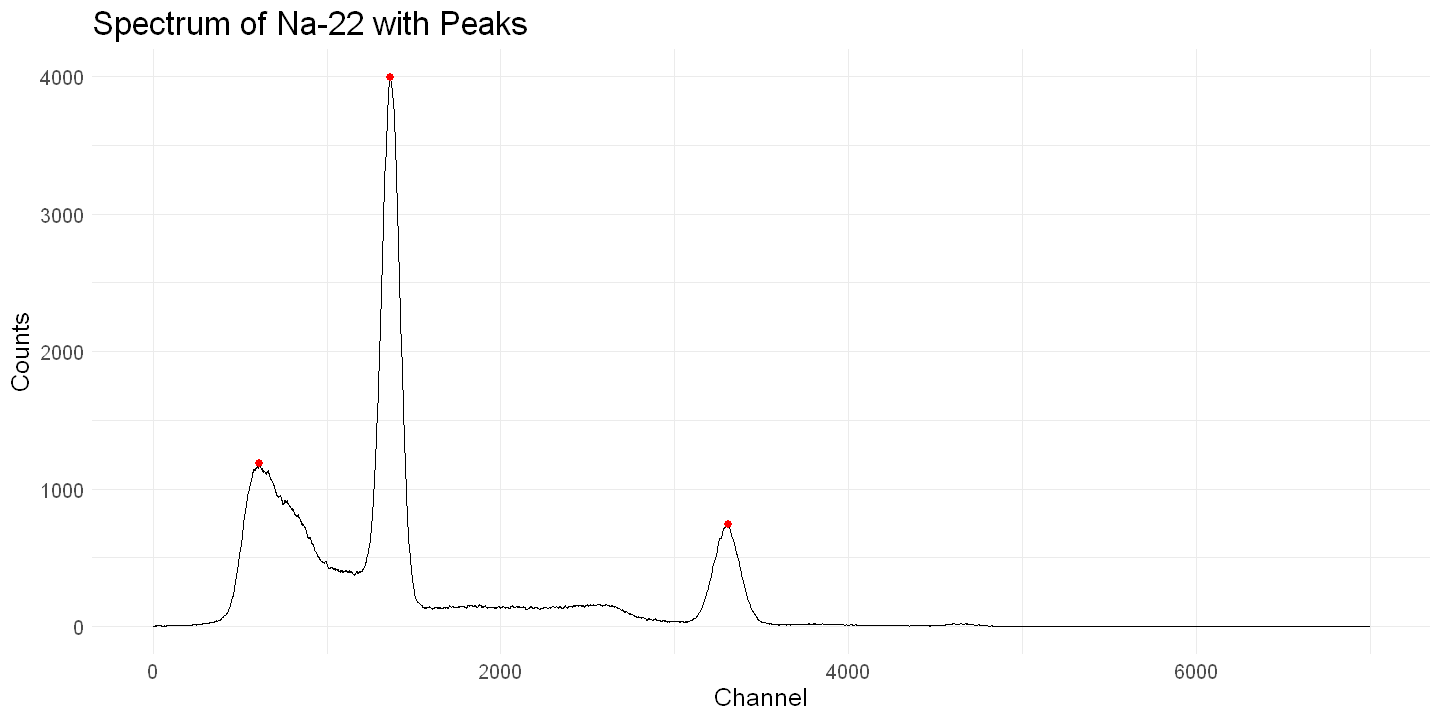

[[1]]
[1] 2279.291

[[2]]
[1] NA

[[3]]
[1] 4587.751

[[4]]
[1] NA



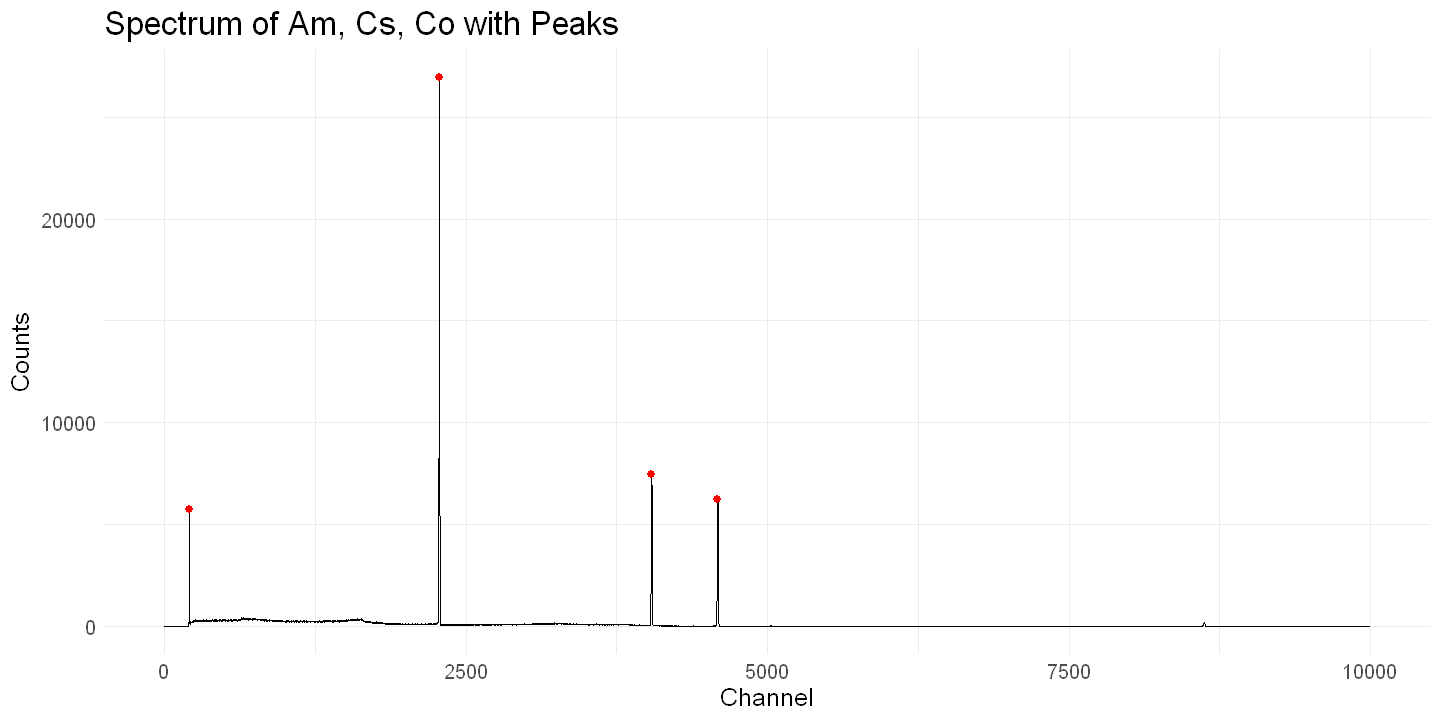

[[1]]
[1] 1503.289

[[2]]
[1] 478.1151

[[3]]
[1] 3672.633

[[4]]
[1] 546.2334



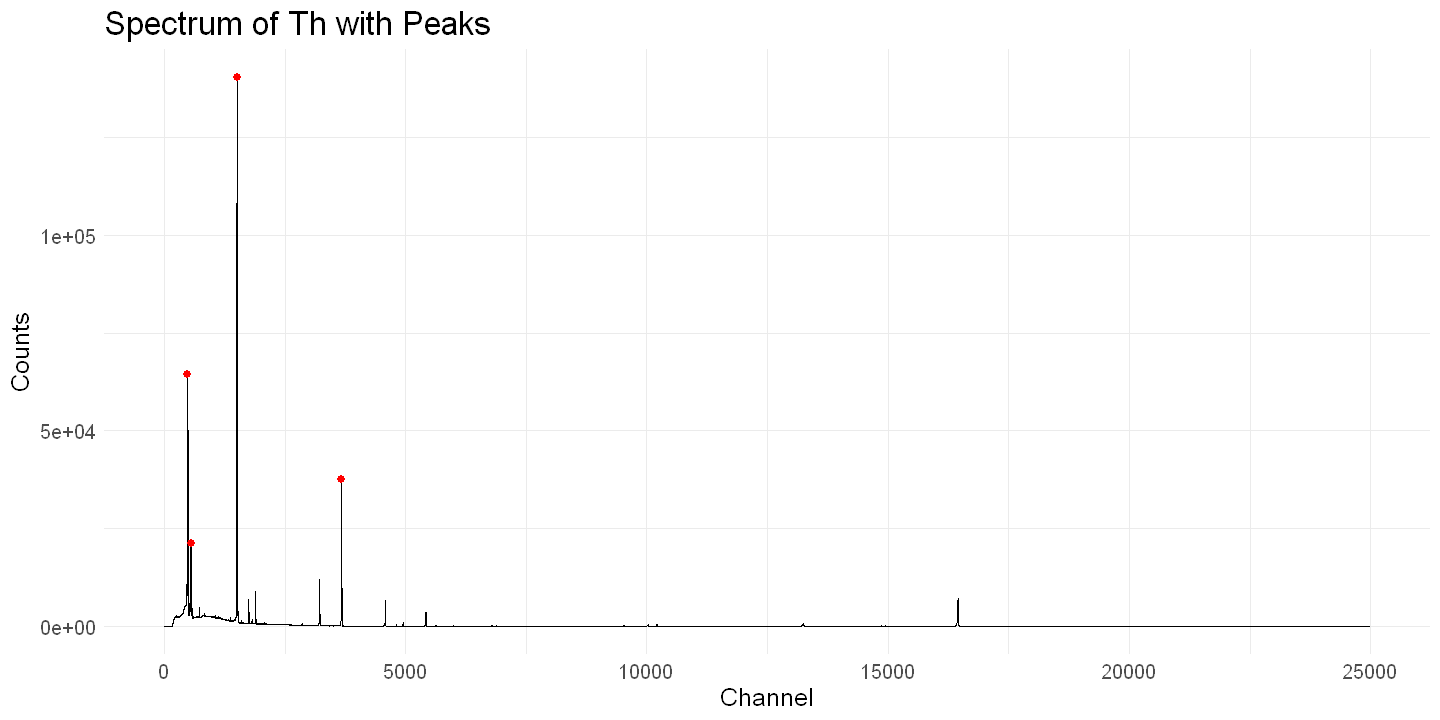

In [ ]:
# Fit and calculate FWHM for peaks in the Co-60 spectrum
peak_positions_co60 <- find_and_plot_peaks(gr11_co60, "Spectrum of Co-60 with Peaks", minpeakheight_factor = 0.5, minpeakdistance = 100, window_size = 5, apply_smoothing = TRUE)
# Loop through peaks and calculate FWHM
fwhm_results_co60 <- lapply(peak_positions_co60, function(pos) fit_gaussian(gr11_co60, pos))
# Filter out NULL results from failed fits
fwhm_results_co60 <- Filter(Negate(is.null), fwhm_results_co60)
# Print the results
fwhm_results_co60

# Cs-137
peak_positions_cs137 <- find_and_plot_peaks(gr11_cs137, "Spectrum of Cs-137 with Peaks", minpeakheight_factor = 0.3, minpeakdistance = 100, window_size = 5, apply_smoothing = TRUE)
fwhm_results_cs137 <- lapply(peak_positions_cs137, function(pos) fit_gaussian(gr11_cs137, pos))
fwhm_results_cs137 <- Filter(Negate(is.null), fwhm_results_cs137)
print(fwhm_results_cs137)

# Na-22
peak_positions_na22 <- find_and_plot_peaks(gr11_na22, "Spectrum of Na-22 with Peaks", minpeakheight_factor = 0.1, minpeakdistance = 300, window_size = 6, apply_smoothing = TRUE)
fwhm_results_na22 <- lapply(peak_positions_na22, function(pos) fit_gaussian(gr11_na22, pos))
fwhm_results_na22 <- Filter(Negate(is.null), fwhm_results_na22)
print(fwhm_results_na22)

# Am, Cs, Co
peak_positions_amcsco <- find_and_plot_peaks(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks", minpeakheight_factor = 0.02, minpeakdistance = 50, window_size = 5, apply_smoothing = FALSE)
fwhm_results_amcsco <- lapply(peak_positions_amcsco, function(pos) fit_gaussian(IC48A_AmCsCo, pos))
fwhm_results_amcsco <- Filter(Negate(is.null), fwhm_results_amcsco)
print(fwhm_results_amcsco)

# Th
peak_positions_th <- find_and_plot_peaks(IC48A_Th, "Spectrum of Th with Peaks", minpeakheight_factor = 0.1, minpeakdistance = 50, window_size = 5, apply_smoothing = FALSE)
fwhm_results_th <- lapply(peak_positions_th, function(pos) fit_gaussian(IC48A_Th, pos))
fwhm_results_th <- Filter(Negate(is.null), fwhm_results_th)
print(fwhm_results_th)

## Step 2: Calibration of Detector
To perform a calibration of the detector, we need to establish a relationship between the channel number (position of the peak) and the known energies of the gamma peaks. Assuming a linear response, this relationship can be expressed as:
$$ E=a⋅x+b $$

where:
* E is the energy in keV,
* x is the channel number,
* a and b are the calibration constants.
We can perform this calibration using a set of known gamma energies corresponding to the detected peaks.

##### Steps to Perform Calibration
Identify Known Gamma Energies: We need to have the nominal gamma peak energies for the isotopes in the data.  
Fit the Line: Use the identified peak positions (centroids) and their corresponding gamma energies to fit a linear model.  
Apply Calibration: Use the linear model to convert channel numbers to energies.  

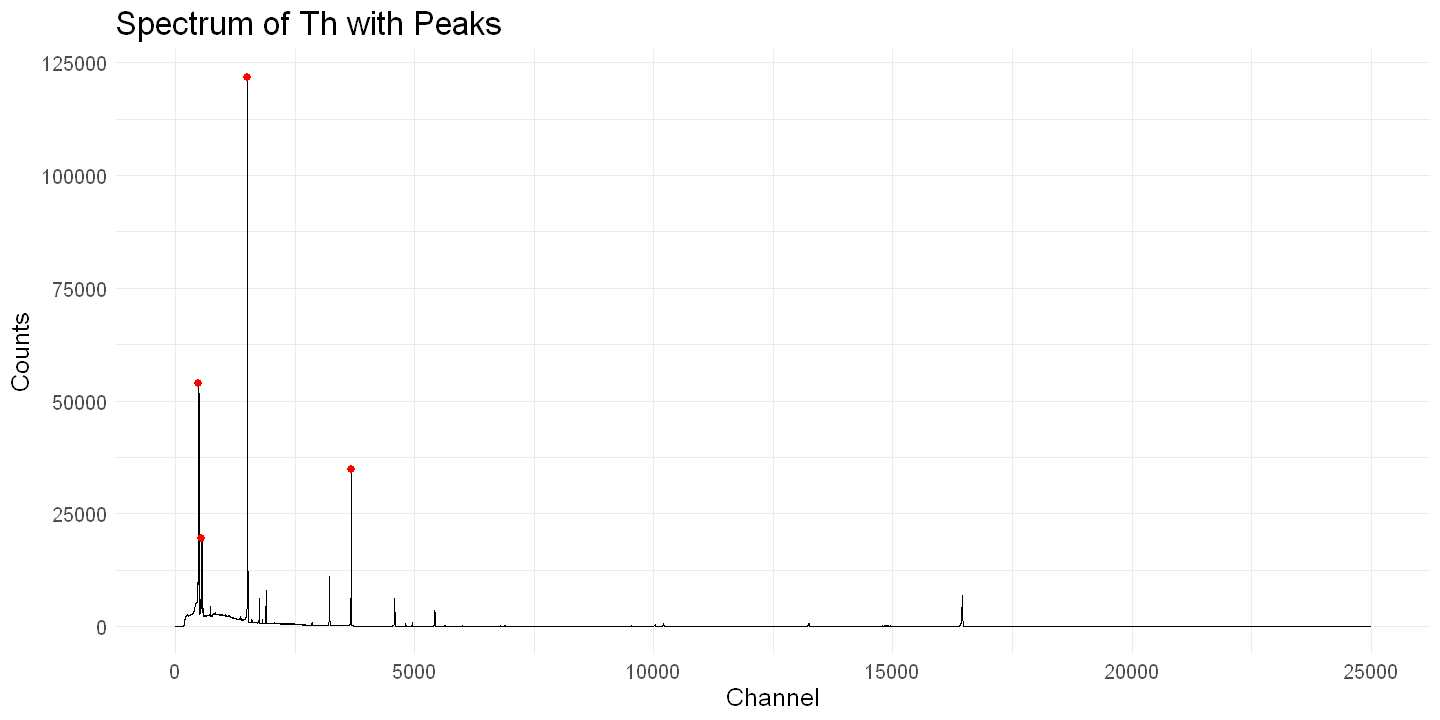

ERROR: Error in model.frame.default(formula = energies ~ centroids, drop.unused.levels = TRUE): le lunghezze variabili differiscono (trovato per 'centroids')


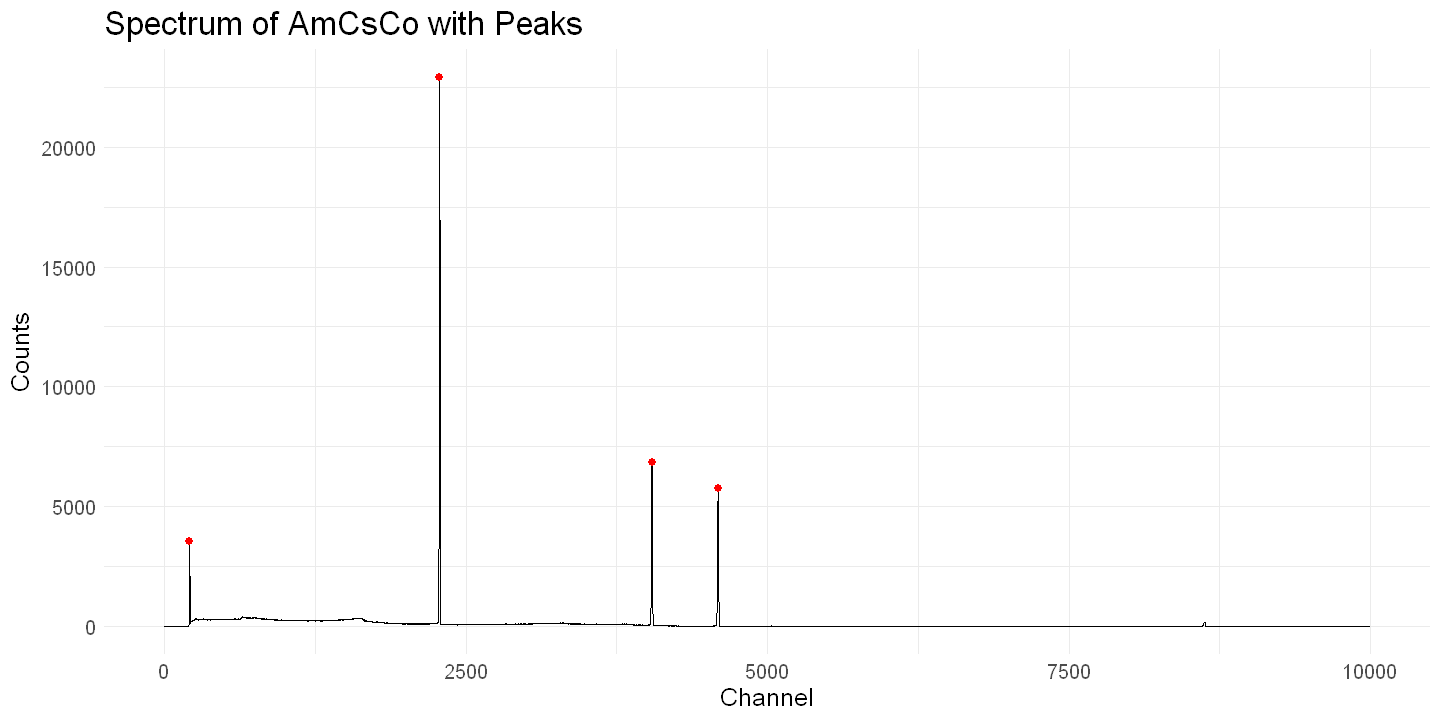

In [ ]:
# Define known energies for Thorium (Th) and AmCsCo (Americium, Cesium, Cobalt)
known_energies <- list(
  Th = c(
    238.632, 300.089, 510.74, 583.187, 727.33, 763.45,
    785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511,
    1620.738, 2103.511, 2614.511
  ),
  AmCsCo = c(
    59.5409, 661.657, 1173.228, 1332.492
  )
)
# Function to smooth data
smooth_data <- function(data, window_size) {
  smoothed_values <- movavg(data$Value, n = window_size, type = "s")
  smoothed_data <- data
  smoothed_data$Value <- smoothed_values
  return(smoothed_data)
}

# Function to fit Gaussian and calculate FWHM
fit_gaussian <- function(data, peak_position) {
  peak_position <- as.numeric(peak_position)
  subset_data <- data %>%
    filter(Row >= (peak_position - 50) & Row <= (peak_position + 50))
  
  start_params <- list(a = max(subset_data$Value), 
                       b = peak_position, 
                       c = sd(subset_data$Row))
  
  fit <- tryCatch({
    nls(Value ~ a * exp(-(Row - b)^2 / (2 * c^2)), 
        data = subset_data, 
        start = start_params,
        control = nls.control(minFactor = 1/2048, maxiter = 100))
  }, error = function(e) {
    NULL
  })
  
  if (!is.null(fit)) {
    params <- summary(fit)$coefficients
    mean <- params["b", "Estimate"]
    return(mean)
  } else {
    return(NA)
  }
}

# Function to extract centroids for known isotopes
extract_centroids <- function(data, known_energies, isotope_name) {
  peak_positions <- find_and_plot_peaks(data, paste("Spectrum of", isotope_name, "with Peaks"))
  centroids <- sapply(peak_positions, function(pos) fit_gaussian(data, pos))
  centroids <- centroids[!is.na(centroids)]
  return(centroids)
}
# Function to extract centroids for known isotopes
extract_centroids <- function(data, known_energies, isotope_name, window_size = 5, minpeakheight_factor = 0.1, minpeakdistance = 20) {
  peak_positions <- find_and_plot_peaks(data, paste("Spectrum of", isotope_name, "with Peaks"), 
                                        window_size = window_size, 
                                        minpeakheight_factor = minpeakheight_factor, 
                                        minpeakdistance = minpeakdistance)
  centroids <- sapply(peak_positions, function(pos) fit_gaussian(data, pos))
  centroids <- centroids[!is.na(centroids)]
  return(centroids)
}
# Extract centroids for Th
centroids_th <- extract_centroids(IC48A_Th, known_energies$Th, "Th")

# Extract centroids for AmCsCo
centroids_amcsco <- extract_centroids(IC48A_AmCsCo, known_energies$AmCsCo, "AmCsCo")

# Combine centroids and known energies
centroids <- c(centroids_th, centroids_amcsco)
energies <- c(rep(known_energies$Th, each = length(centroids_th)), rep(known_energies$AmCsCo, each = length(centroids_amcsco)))

# Fit linear model (calibration)
calibration <- lm(energies ~ centroids)

# Print the calibration coefficients
summary(calibration)


In [ ]:
# Perform linear regression for calibration
calibration_model <- lm(energies ~ centroids)

# Calibration constants
a <- coef(calibration_model)[2]
b <- coef(calibration_model)[1]

# Print calibration constants
cat("Calibration equation: Energy (keV) =", round(a, 2), "* Channel +", round(b, 2), "\n")


ERROR: Error in model.frame.default(formula = energies ~ centroids, drop.unused.levels = TRUE): le lunghezze variabili differiscono (trovato per 'centroids')


In [ ]:
# Function to apply calibration
apply_calibration <- function(data, a, b) {
  data %>%
    mutate(Energy = a * Row + b)
}

# Apply calibration to all data sets
calibrated_gr11_co60 <- apply_calibration(gr11_co60, a, b)
calibrated_gr11_cs137 <- apply_calibration(gr11_cs137, a, b)
calibrated_gr11_na22 <- apply_calibration(gr11_na22, a, b)
calibrated_IC48A_AmCsCo <- apply_calibration(IC48A_AmCsCo, a, b)
calibrated_IC48A_Th <- apply_calibration(IC48A_Th, a, b)

# Function to plot calibrated spectra
plot_calibrated_spectrum <- function(data, title) {
  ggplot(data, aes(x = Energy, y = Value)) +
    geom_line() +
    ggtitle(title) +
    xlab("Energy (keV)") +
    ylab("Counts") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

# Plot calibrated spectra
plot_co60 <- plot_calibrated_spectrum(calibrated_gr11_co60, "Calibrated Spectrum of Co-60")
plot_cs137 <- plot_calibrated_spectrum(calibrated_gr11_cs137, "Calibrated Spectrum of Cs-137")
plot_na22 <- plot_calibrated_spectrum(calibrated_gr11_na22, "Calibrated Spectrum of Na-22")
plot_amcsco <- plot_calibrated_spectrum(calibrated_IC48A_AmCsCo, "Calibrated Spectrum of Am, Cs, Co")
plot_th <- plot_calibrated_spectrum(calibrated_IC48A_Th, "Calibrated Spectrum of Th")

# Display plots
grid.arrange(plot_co60, plot_cs137, plot_na22, plot_amcsco, plot_th, ncol = 1)


### Step 3: Study Energy Resolution Using MCMC:
Using MCMC methods (with either JAGS or Stan), study the behavior of energy resolution as a function of photon energy.
Infer the parameters of the equations for FWHM and its components.